# Plot a zarr archive 
### and animate a selected variable

In [2]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import anemoi.datasets as ad
import numpy as np
import matplotlib.animation as animation
from utils import mesh, interpolate, subset_variable, update_anim, simple_mesh_plot

#import sys # use to import functions from some other folder like the inference dir
#sys.path.append("/lustre/storeB/project/fou/hi/foccus/ina/ocean-ai/inference")

### Using anemoi-datasets to open and look at the data

In [4]:
dir = '/lustre/storeB/project/fou/hi/foccus/datasets/prepro_norkyst_tests/'
file = dir + 'norkyst800_his_zdepth_2024_m00_AN_ml.zarr'
#file = dir + 'norkyst800_his_zdepth_2024_temp_m00_AN_ml.zarr'
zda = ad.open_dataset(file)

Select the variable and number of time steps

In [5]:
ntime = 12
var_name = 'temperature_1'
indx_var = zda.name_to_index[var_name]
var_norway = zda[:ntime,indx_var,0,:]

longitude = zda.longitudes
latitude = zda.latitudes

Are the arrays equidistant?

In [6]:
differences = np.diff(np.sort(np.unique(longitude)))
are_same = np.all(differences == differences[0])

In [7]:
are_same

False

In [8]:
for i in range(-10,-1):
#for i in range(10):
    print(longitude[i+1]-longitude[i])

0.018879064309263782
0.018894900344765375
0.018910752198912917
0.01892661988446065
0.01894250341413084
0.018958402800617336
0.01897431805665306
0.018990249194917652
0.019006196228094296


In [9]:
#for i in range(-10,-1):
for i in range(10):
    print(latitude[i+1]-latitude[i])

0.006122022389014603
0.0061218909027473956
0.006121759174803287
0.006121627204990432
0.0061214949931809315
0.006121362539232678
0.00612122984297514
0.006121096904287526
0.0061209637230348335
0.006120830299025215


### Get a subset of the dataset 
Default: Lofoten & Vesterålen, Northern Norway

In [11]:
lon_min, lon_max = 11.83083, 15.59072
lat_min, lat_max = 67.41791, 69.20699

var, lat, lon = subset_variable(var_norway,latitude,longitude,lat_min,lat_max,lon_min,lon_max)
#del var_norway, longitude, latitude

The zarr data provides 1D arrays which are representing the 2D data. We use meshgrid and an interpolation to map the data back to 2D arrays. 

Note: Resolution of the grid needs to be set. If it is too small the plotting/animation will be very slow. But you want to see small features too. Find a middle ground.

In [12]:
resolution=0.01 # TODO try smaller than 0.25, this is same as MEPS I think?
lat_grid, lon_grid = mesh(lat, lon, resolution)
# TODO: no need to call mesh here an also inside interpolate...

var_interp = np.empty([ntime,lat_grid.shape[0],lat_grid.shape[1]])
for itime in range(ntime):
    var_interp[itime] = interpolate(var[itime], lat, lon, resolution)

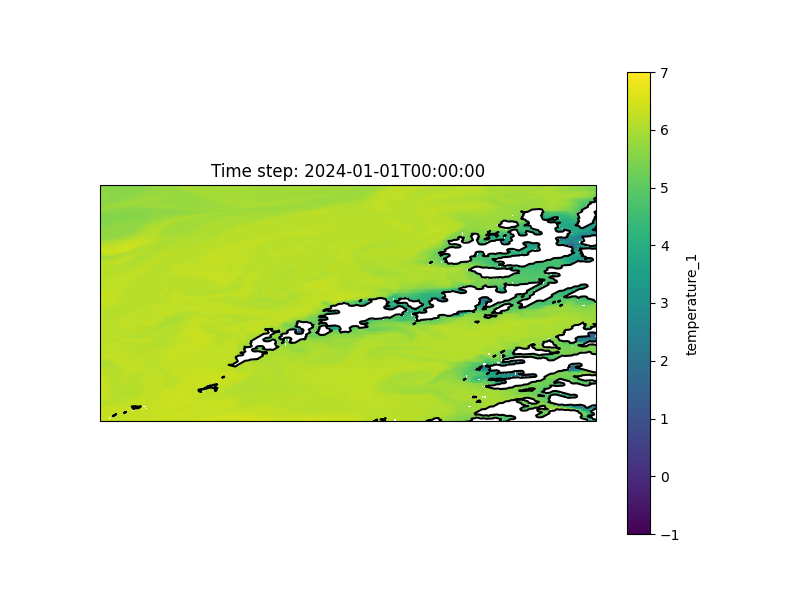

In [13]:
time_steps = zda.dates
vmin = round(np.nanmin(var_interp) - 0.2)
vmax = round(np.nanmax(var_interp) + 0.2)
# Initialize the plot at t=0
fig, ax1, heatmap = simple_mesh_plot(var_interp[0],lat_grid,lon_grid,time_steps[0],
                                     var_name,vmin,vmax)

# Start the animation:
# set interval=500 for a slower anim
ani = animation.FuncAnimation(fig, update_anim, frames=ntime, interval=200,fargs=(ax1, heatmap, var_interp, time_steps))

Save the animation as a GIF (optional)

**NOTE:** only possible if the imagemagick package ia installed already

In [14]:
#ani.save('zarr_animation.gif', writer='imagemagick')

## Plot landmask 

In [97]:
# Load contour paths from the .npy file
dir_save = '/lustre/storeB/project/fou/hi/foccus/ina/ocean-ai/plot/'
contour_loaded = np.load(dir_save + 'surface_mask_contour_paths.npy', allow_pickle=True)

Text(0.5, 1.0, 'Land-Sea Border')

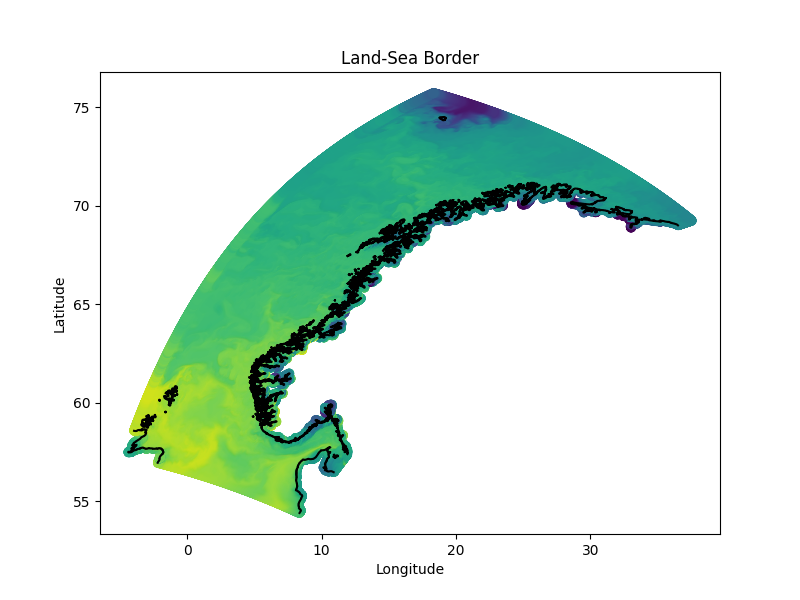

In [98]:
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.pcolormesh(lon_grid,lat_grid,var_interp[0])
ax3.scatter(longitude, latitude, c=var_norway[0])

# Plot each contour path
for vertices in contour_loaded:
    ax3.plot(vertices[:, 0], vertices[:, 1], color='black')

# Add labels and a title
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Land-Sea Border')

Some other non-plotting things:
### Exploring the dataset using anemoi-datasets
Using various anemoi-datasets functions which are useful to know. 

In [ ]:
dates_all = zda.dates
type(dates_all)
time_diffs = np.diff(dates_all)
#print(time_diffs,len(dates_all))

# Check if all differences are the same
consistent_intervals = np.all(time_diffs == time_diffs[0])

print("All time intervals are consistent (have the same distance in time):", consistent_intervals)

In [ ]:
zda.variables

In [ ]:
# Data shap'en
# (24, 16, 1, 3153556) 
# tilsvarer i dette tilfellet: 24 tidssteg, 16 variables, 1 ensemble, ~3M gridpoints
zda.shape # samme som zda.data.shape

In [ ]:
# Print the methods of the dataset
dir(zda)

In [ ]:
zda.variables_metadata['temperature_1']
#zda.variables_metadata['zeta']

In [ ]:
# name_to_index will print all the variable names (16 of them) 
# and their indexes so we know how to access a variable by index
zda.name_to_index